<a href="https://colab.research.google.com/github/ridabayi/Data_Analysis/blob/main/Feature_engineering_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00


## Importing Required Libraries

In [4]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import tqdm
from numpy import median
import random
import catboost as cb
import lightgbm as lgb
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [5]:
def rmse(actual, predicted):
    return mean_squared_error(actual, predicted, squared=False)

In [6]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0CRSEN/LargeData/train_data.csv", parse_dates=['startdate'], index_col=0)
df.head()

,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,31.52,...,-27.68,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58
1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,31.52,...,-21.13,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42
2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,31.52,...,-10.72,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82
3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,31.52,...,0.33,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74
4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,31.52,...,9.83,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95


In [7]:
df.shape

(375734, 245)

In [8]:
target = 'contest-tmp2m-14d__tmp2m'
df[target]

index
0         28.744480
1         28.370585
2         28.133059
3         28.256798
4         28.372353
            ...    
375729    17.150954
375730    16.962051
375731    16.915474
375732    16.536761
375733    15.910995
Name: contest-tmp2m-14d__tmp2m, Length: 375734, dtype: float64

## Preprocessing the dataset

In [9]:
def loc_group(df):

    scale = 14

    df['lat'] = np.round(df['lat'], scale)
    df['lon'] = np.round(df['lon'], scale)
    df['loc_group'] = df.groupby(['lon', 'lat']).ngroup()

    return df

In [10]:
df = loc_group(df)
df.loc_group.nunique()

514

In [11]:
n_startdates = []

for n in range(df.loc_group.nunique()):
    n_startdates.append(df[df.loc_group == n].startdate.nunique())

print(n_startdates)
print()
print(df.startdate.nunique())

[731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731, 731,

## Fill Missing Values

In [12]:
na_cols = []

for col in df.columns:
    if df[col].isnull().sum() >0:
        na_cols.append(col)
        print(col, df[col].isnull().sum())

nmme0-tmp2m-34w__ccsm30 15934
nmme-tmp2m-56w__ccsm3 10280
nmme-prate-34w__ccsm3 8738
nmme0-prate-56w__ccsm30 15934
nmme0-prate-34w__ccsm30 15934
nmme-prate-56w__ccsm3 10280
nmme-tmp2m-34w__ccsm3 8738
ccsm30 15934


In [13]:
forecast_na_cols = ['nmme0-tmp2m-34w__ccsm30',
 'nmme-tmp2m-56w__ccsm3',
 'nmme-prate-34w__ccsm3',
 'nmme0-prate-56w__ccsm30',
 'nmme0-prate-34w__ccsm30',
 'nmme-prate-56w__ccsm3',
 'nmme-tmp2m-34w__ccsm3']


forecast_mean_cols = ['nmme0-tmp2m-34w__nmme0mean',
 'nmme-tmp2m-56w__nmmemean',
 'nmme-prate-34w__nmmemean',
 'nmme0-prate-56w__nmme0mean',
 'nmme0-prate-34w__nmme0mean',
 'nmme-prate-56w__nmmemean',
 'nmme-tmp2m-34w__nmmemean']


nmme0_tmp2m_34w = ['nmme0-tmp2m-34w__cancm30',
'nmme0-tmp2m-34w__cancm40',
'nmme0-tmp2m-34w__ccsm40',
'nmme0-tmp2m-34w__cfsv20',
'nmme0-tmp2m-34w__gfdlflora0',
'nmme0-tmp2m-34w__gfdlflorb0',
'nmme0-tmp2m-34w__gfdl0',
'nmme0-tmp2m-34w__nasa0']

nmme_tmp2m_56w = ['nmme-tmp2m-56w__cancm3',
'nmme-tmp2m-56w__cancm4',
'nmme-tmp2m-56w__ccsm4',
'nmme-tmp2m-56w__cfsv2',
'nmme-tmp2m-56w__gfdl',
'nmme-tmp2m-56w__gfdlflora',
'nmme-tmp2m-56w__gfdlflorb',
'nmme-tmp2m-56w__nasa']

nmme_prate_34w = ['nmme-prate-34w__cancm3',
'nmme-prate-34w__cancm4',
'nmme-prate-34w__ccsm4',
'nmme-prate-34w__cfsv2',
'nmme-prate-34w__gfdl',
'nmme-prate-34w__gfdlflora',
'nmme-prate-34w__gfdlflorb',
'nmme-prate-34w__nasa']

nmme0_prate_56w = [ 'nmme0-prate-56w__cancm30',
'nmme0-prate-56w__cancm40',
'nmme0-prate-56w__ccsm40',
'nmme0-prate-56w__cfsv20',
'nmme0-prate-56w__gfdlflora0',
'nmme0-prate-56w__gfdlflorb0',
'nmme0-prate-56w__gfdl0',
'nmme0-prate-56w__nasa0']

nmme0_prate_34w = ['nmme0-prate-34w__cancm30',
'nmme0-prate-34w__cancm40',
'nmme0-prate-34w__ccsm40',
'nmme0-prate-34w__cfsv20',
'nmme0-prate-34w__gfdlflora0',
'nmme0-prate-34w__gfdlflorb0',
'nmme0-prate-34w__gfdl0',
'nmme0-prate-34w__nasa0']

nmme_prate_56w = ['nmme-prate-56w__cancm3',
'nmme-prate-56w__cancm4',
'nmme-prate-56w__ccsm4',
'nmme-prate-56w__cfsv2',
'nmme-prate-56w__gfdl',
'nmme-prate-56w__gfdlflora',
'nmme-prate-56w__gfdlflorb',
'nmme-prate-56w__nasa']

nmme_tmp2m_34w = ['nmme-tmp2m-34w__cancm3',
'nmme-tmp2m-34w__cancm4',
'nmme-tmp2m-34w__ccsm4',
'nmme-tmp2m-34w__cfsv2',
'nmme-tmp2m-34w__gfdl',
'nmme-tmp2m-34w__gfdlflora',
'nmme-tmp2m-34w__gfdlflorb',
'nmme-tmp2m-34w__nasa']

forecast_cols = [nmme0_tmp2m_34w, nmme_tmp2m_56w, nmme_prate_34w, nmme0_prate_56w, nmme0_prate_34w, nmme_prate_56w, nmme_tmp2m_34w]

In [14]:
def impute_missing_values(df):

    for i, na_col in enumerate(forecast_na_cols):
        total = df[forecast_mean_cols[i]] * 9
        sum_of_8_forecast = df[forecast_cols[i]].sum(axis=1)
        df[na_col] = total - sum_of_8_forecast

    return df

In [15]:
df = impute_missing_values(df)

In [16]:
def drop_redundant_col(df):

    df.drop(['ccsm30'], axis=1, inplace=True)

    return df

In [17]:
df = drop_redundant_col(df)

In [18]:
df.isnull().sum().sum()

0

## Feature Selection and Lasso Regressions (to Obtain Residuals)¶

### Spliting the data

In [19]:
df.sort_values(by=['loc_group', 'startdate'], inplace=True, ignore_index=True)

In [20]:
df.head()

,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,loc_group
0,0.590909,0.0,2014-09-01,731.27,24.08,23.28,19.34,20.35,17.97,19.48,...,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58,0
1,0.590909,0.0,2014-09-02,711.89,24.08,23.28,19.34,20.35,17.97,19.48,...,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42,0
2,0.590909,0.0,2014-09-03,683.18,24.08,23.28,19.34,20.35,17.97,19.48,...,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82,0
3,0.590909,0.0,2014-09-04,649.02,24.08,23.28,19.34,20.35,17.97,19.48,...,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74,0
4,0.590909,0.0,2014-09-05,582.21,24.08,23.28,19.34,20.35,17.97,19.48,...,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95,0


In [21]:
train = df[df["startdate"] <= pd.datetime(2015, 11, 15)]
val = df[(df["startdate"] > pd.datetime(2015, 11, 15)) & (df["startdate"] <= pd.datetime(2016, 4, 8))]
test = df[df["startdate"] > pd.datetime(2016, 4, 8)]

print(f'Train_shape: {train.shape}  |  Val_shape: {val.shape}   |  Test_shape: {test.shape}')

Train_shape: (226674, 245)  |  Val_shape: (74530, 245)   |  Test_shape: (74530, 245)


### Feature Selection

In [22]:
LR_cols = []

for col in df.columns:
    if '14d' in col and col != target:
        corr = df[[col, target]].corr().iloc[0,1]
        if np.abs(corr) > 0.8:
            print(col, corr)
            LR_cols.append(col)

contest-pevpr-sfc-gauss-14d__pevpr 0.8053009996220467
contest-wind-h100-14d__wind-hgt-100 0.898186990483465
contest-wind-h500-14d__wind-hgt-500 0.8841771695589746


In [23]:
prefixs = []

for col in df.columns:
    if '34w' in col or '56w' in col:
        prefix = col.split("__")[0]
        prefixs.append(prefix)

prefixs = list(set(prefixs))
prefixs

['nmme0-tmp2m-34w',
 'nmme0-prate-56w',
 'nmme-tmp2m-34w',
 'nmme-tmp2m-56w',
 'nmme0-prate-34w',
 'nmme-prate-56w',
 'nmme-prate-34w']

In [24]:
pca = PCA(n_components=1)
y = np.array(df[target]).reshape(1, -1)

for prefix in prefixs:

    cols = [col for col in df.columns if prefix in col and 'mean' not in col]
    pca1 = pca.fit_transform(df[cols]).reshape(1, -1)
    print(prefix, f"| pca1 explained variance: {pca.explained_variance_ratio_[0]}")
    print(f"pca1 vs target corr: {np.corrcoef(pca1, y)[1,0]}")
    print()

nmme0-tmp2m-34w | pca1 explained variance: 0.9766670636759252
pca1 vs target corr: -0.8510460209544227

nmme0-prate-56w | pca1 explained variance: 0.7200377592938519
pca1 vs target corr: -0.0018278113335758051

nmme-tmp2m-34w | pca1 explained variance: 0.971881767554349
pca1 vs target corr: -0.9501574246214115

nmme-tmp2m-56w | pca1 explained variance: 0.9745715199798329
pca1 vs target corr: -0.9507973950482158

nmme0-prate-34w | pca1 explained variance: 0.720459574294314
pca1 vs target corr: -0.053929212683078515

nmme-prate-56w | pca1 explained variance: 0.756061976222882
pca1 vs target corr: -0.1686608099615376

nmme-prate-34w | pca1 explained variance: 0.7614083062893766
pca1 vs target corr: -0.17623054345156972



In [25]:
corr_prefix = ['nmme0-tmp2m-34w', 'nmme-tmp2m-34w', 'nmme-tmp2m-56w']

corr_prefix_cols = [nmme0_tmp2m_34w, nmme_tmp2m_34w, nmme_tmp2m_56w]

for prefix, cols in zip(corr_prefix, corr_prefix_cols):
    pc_name = prefix + '-pc'
    pca = PCA(n_components=1)
    pca.fit(df[cols])
    for ds in [train, val, test]:
        ds[pc_name] = pca.fit_transform(ds[cols])

In [26]:
LR_cols = LR_cols + [prefix+'-pc' for prefix in corr_prefix]
LR_cols

['contest-pevpr-sfc-gauss-14d__pevpr',
 'contest-wind-h100-14d__wind-hgt-100',
 'contest-wind-h500-14d__wind-hgt-500',
 'nmme0-tmp2m-34w-pc',
 'nmme-tmp2m-34w-pc',
 'nmme-tmp2m-56w-pc']

In [27]:
for col in df.columns:

    if df[col].dtype == 'float64' and col not in LR_cols and 'nmme0-tmp2m-34w' not in col and 'nmme-tmp2m-34w' not in col and 'nmme-tmp2m-56w' not in col:
        corr = df[[col, target]].corr().iloc[0,1]
        if np.abs(corr) > 0.8:
            LR_cols.append(col)
            print(col, corr)

contest-tmp2m-14d__tmp2m 1.0
wind-hgt-500-2010-1 -0.8060782090050108
wind-hgt-10-2010-1 -0.8157008804019407
wind-hgt-100-2010-1 -0.802239950441264
wind-vwnd-925-2010-1 -0.8073710173926125


In [28]:
LR_cols = [col for col in LR_cols if col != target]
LR_cols

['contest-pevpr-sfc-gauss-14d__pevpr',
 'contest-wind-h100-14d__wind-hgt-100',
 'contest-wind-h500-14d__wind-hgt-500',
 'nmme0-tmp2m-34w-pc',
 'nmme-tmp2m-34w-pc',
 'nmme-tmp2m-56w-pc',
 'wind-hgt-500-2010-1',
 'wind-hgt-10-2010-1',
 'wind-hgt-100-2010-1',
 'wind-vwnd-925-2010-1']

## Selecting Alpha and Fitting Linear Regressions (to Obtain Residuals)

In [29]:
def LR_models(alpha, selected_feats, shift_feats):

    # new train and vaidation dataset containing only the selected features
    X_train, y_train = train[selected_feats], train[target]
    X_val, y_val = val[selected_feats], val[target]

    train_se = 0
    val_se = 0

    # loop through 514 different locations,
    # for each location we create a machine learning pipeline and fit a linear regression model
    for i in range(df.loc_group.nunique()):

        # train and validation dataset for the ith location
        X1_train = X_train[train["loc_group"]==i]
        y1_train = y_train[train["loc_group"]==i]
        X1_val = X_val[val["loc_group"]==i]
        y1_val = y_val[val["loc_group"]==i]

        # collect the indices of the observations, which we will use to recover the train and val split of the data
        t_index = X_train[train["loc_group"]==i].index
        v_index = X_val[val["loc_group"]==i].index

        # if shift_feats, we combine the train and val set to shift the "34w" and "56w" features
        if shift_feats == True and np.any(['34w' in col or '56w' in col for col in selected_feats]):
            X1_conc = pd.concat([X1_train, X1_val])
            for col in selected_feats:
                if '34w' in col:
                    X1_conc[col] = X1_conc[col].shift(-14).ffill()
                if '56w' in col:
                    X1_conc[col] = X1_conc[col].shift(-28).ffill()

            # we recover the train and val set by their respective list of indices
            X1_train = X1_conc.loc[t_index, :]
            X1_val = X1_conc.loc[v_index, :]

        # scale the data
        ss = StandardScaler()
        X1_train_ss = ss.fit_transform(X1_train)
        X1_val_ss = ss.transform(X1_val)

        # fit the linear regression model with alpha as the regularization parameter
        LR = Lasso(alpha=alpha, max_iter=10000)
        LR.fit(X1_train_ss, y1_train)
        y1_train_pred = LR.predict(X1_train_ss)
        y1_val_pred = LR.predict(X1_val_ss)

        # accumulate the total squared errors by the sum of squared errors from the ith location
        train_se += mean_squared_error(y1_train, y1_train_pred) * len(t_index)
        val_se += mean_squared_error(y1_val, y1_val_pred) * len(v_index)

    # return the root mean squared error of train and validation set
    train_rmse = np.round(np.sqrt(train_se / X_train.shape[0]), 3)
    val_rmse = np.round(np.sqrt(val_se / X_val.shape[0]), 3)

    return train_rmse, val_rmse

In [30]:
train_rmses = []
val_rmses = []
alphas = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.8, 1, 1.5, 2, 2.5, 3, 3.5, 4]

for alpha in alphas:

    print(f"alpha = {alpha}...")
    train_rmse, val_rmse = LR_models(alpha, LR_cols, True)
    train_rmses.append(train_rmse)
    val_rmses.append(val_rmse)

alpha = 0.001...
alpha = 0.01...
alpha = 0.05...
alpha = 0.1...
alpha = 0.15...
alpha = 0.2...
alpha = 0.25...
alpha = 0.3...
alpha = 0.5...
alpha = 0.8...
alpha = 1...
alpha = 1.5...
alpha = 2...
alpha = 2.5...
alpha = 3...
alpha = 3.5...
alpha = 4...


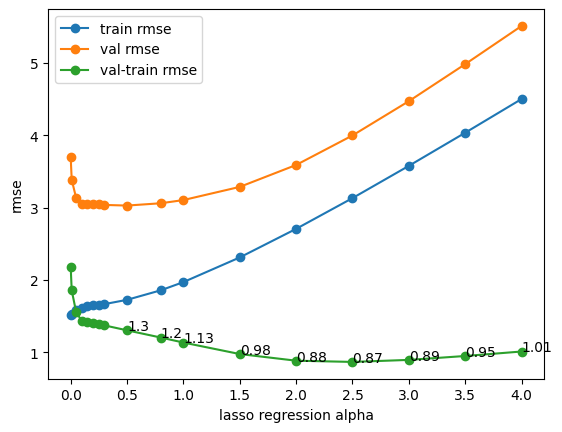

In [31]:
plt.plot(alphas, train_rmses, 'o-', label="train rmse")
plt.plot(alphas, val_rmses,'o-', label="val rmse")
plt.plot(alphas, np.array(val_rmses)-np.array(train_rmses), 'o-', label="val-train rmse")

for i in np.arange(8, len(alphas)):
    plt.annotate(f"{np.round(val_rmses[i]-train_rmses[i], 2)}", (alphas[i], val_rmses[i]-train_rmses[i]))

plt.xlabel("lasso regression alpha")
plt.ylabel("rmse")
plt.legend(loc='best')
plt.show()

In [32]:
train2 = pd.concat([train, val], axis=0)
print(f'Train2_shape: {train2.shape}  |  Test_shape: {test.shape}')

Train2_shape: (301204, 248)  |  Test_shape: (74530, 248)


In [33]:
def LR_models_residuals(selected_feats, shift_feats):

    # new train and test dataset containing only the selected features
    X_train, y_train = train2[selected_feats], train2[target]
    X_test, y_test = test[selected_feats], test[target]

    pred_residuals = np.zeros(df.shape[0])
    predictions = np.zeros(df.shape[0])

    # loop through 514 different locations,
    # for each location we create a machine learning pipeline and fit a linear regression model
    for i in range(df.loc_group.nunique()):

        # train and test dataset for the ith location
        X1_train = X_train[train2["loc_group"]==i]
        y1_train = y_train[train2["loc_group"]==i]
        X1_test = X_test[test["loc_group"]==i]
        y1_test = y_test[test["loc_group"]==i]

        # collect the indices of the observations, which we will use to recover the train and test split of the data
        t_index = X_train[train2["loc_group"]==i].index
        te_index = X_test[test["loc_group"]==i].index

        # if shift_feats, we combine the train and test set to shift the "34w" and "56w" features
        if shift_feats == True and np.any(['34w' in col or '56w' in col for col in selected_feats]):
            X1_conc = pd.concat([X1_train, X1_test])
            for col in selected_feats:
                if '34w' in col:
                    X1_conc[col] = X1_conc[col].shift(-14).ffill()
                if '56w' in col:
                    X1_conc[col] = X1_conc[col].shift(-28).ffill()

            # we recover the train and test set by their respective list of indices
            X1_train = X1_conc.loc[t_index, :]
            X1_test = X1_conc.loc[te_index, :]

        # scale the data
        ss = StandardScaler()
        X1_train_ss = ss.fit_transform(X1_train)
        X1_test_ss = ss.transform(X1_test)

        # fit the linear regression model with alpha = 2.0 as the regularization parameter
        LR = Lasso(alpha=2.0, max_iter=10000)
        LR.fit(X1_train_ss, y1_train)
        y1_train_pred = LR.predict(X1_train_ss)
        y1_test_pred = LR.predict(X1_test_ss)
        predictions[t_index] = y1_train_pred
        predictions[te_index] = y1_test_pred

        # return predicted residuals
        pred_residuals[t_index] = y1_train - y1_train_pred
        pred_residuals[te_index] = y1_test - y1_test_pred

    return pred_residuals, predictions

In [34]:
pred_residuals, predictions = LR_models_residuals(LR_cols, True)

In [35]:
print(len(pred_residuals) == df.shape[0])

True


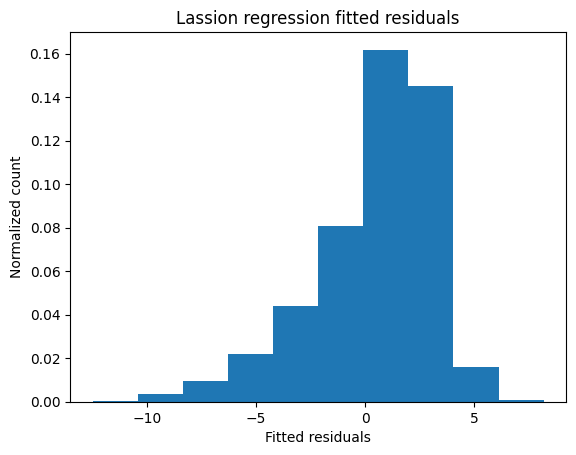

In [36]:
plt.hist(pred_residuals, density=True)
plt.xlabel("Fitted residuals")
plt.ylabel("Normalized count")
plt.title("Lassion regression fitted residuals")
plt.show()

## Boosting Algorithms to Predict Residuals

In [37]:
df['residuals'] = pred_residuals
df.residuals.isnull().sum()

0

In [38]:
del pred_residuals

In [39]:
train2['residuals'] = df.loc[train2.index, 'residuals']
test['residuals'] = df.loc[test.index, 'residuals']

## Feature Selection for Boosting

In [40]:
forecast_means = [col for col in df.columns if 'mean' in col]
forecast_means

['nmme0-tmp2m-34w__nmme0mean',
 'nmme-tmp2m-56w__nmmemean',
 'nmme-prate-34w__nmmemean',
 'nmme0-prate-56w__nmme0mean',
 'nmme0-prate-34w__nmme0mean',
 'nmme-prate-56w__nmmemean',
 'nmme-tmp2m-34w__nmmemean',
 'nmme0mean']

In [41]:
B_cols = []

for col in forecast_means:
    if '34w' in col:
        df[col+'_shifted'] = df.groupby(['loc_group'])[col].shift(-14).ffill()
        B_cols.append(col+'_shifted')
    elif '56w' in col:
        df[col+'_shifted'] = df.groupby(['loc_group'])[col].shift(-28).ffill()
        B_cols.append(col+'_shifted')
    else:
        B_cols.append(col)

In [42]:
for ds in [train2, test]:
    for col in B_cols:
        ds[col] = df.loc[ds.index, col]

print(train2.shape, test.shape)

(301204, 256) (74530, 256)


In [43]:
for col in df.columns:
    if '14d' in col:
        B_cols.append(col)

In [44]:
LE = LabelEncoder()
LE.fit(train2['climateregions__climateregion'])
train2['climateregions__climateregion'] = LE.transform(train2['climateregions__climateregion'])
test['climateregions__climateregion'] = LE.transform(test['climateregions__climateregion'])

In [45]:
df['month'] = df['startdate'].dt.month
df.groupby(['month'])['residuals'].median()

month
1    -2.333870
2    -0.468863
3     0.756814
4     0.966043
5     1.464542
6     2.949630
7     2.905138
8     2.516673
9     2.129676
10    1.038387
11   -2.619120
12   -2.845659
Name: residuals, dtype: float64

In [46]:
for ds in [train2, test]:
    ds['month'] = ds['startdate'].dt.month

In [47]:
B_cols += ['climateregions__climateregion', 'month', 'loc_group', 'elevation__elevation']

print(f"We have {len(B_cols)} features for fitting the Boosting models.")
B_cols

We have 27 features for fitting the Boosting models.


['nmme0-tmp2m-34w__nmme0mean_shifted',
 'nmme-tmp2m-56w__nmmemean_shifted',
 'nmme-prate-34w__nmmemean_shifted',
 'nmme0-prate-56w__nmme0mean_shifted',
 'nmme0-prate-34w__nmme0mean_shifted',
 'nmme-prate-56w__nmmemean_shifted',
 'nmme-tmp2m-34w__nmmemean_shifted',
 'nmme0mean',
 'contest-pevpr-sfc-gauss-14d__pevpr',
 'contest-wind-h10-14d__wind-hgt-10',
 'contest-rhum-sig995-14d__rhum',
 'contest-wind-h100-14d__wind-hgt-100',
 'contest-tmp2m-14d__tmp2m',
 'contest-slp-14d__slp',
 'contest-wind-vwnd-925-14d__wind-vwnd-925',
 'contest-pres-sfc-gauss-14d__pres',
 'contest-wind-uwnd-250-14d__wind-uwnd-250',
 'contest-prwtr-eatm-14d__prwtr',
 'contest-wind-vwnd-250-14d__wind-vwnd-250',
 'contest-precip-14d__precip',
 'contest-wind-h850-14d__wind-hgt-850',
 'contest-wind-uwnd-925-14d__wind-uwnd-925',
 'contest-wind-h500-14d__wind-hgt-500',
 'climateregions__climateregion',
 'month',
 'loc_group',
 'elevation__elevation']

In [48]:
del ds

## Boosting Models for Predicting Fitted Residuals

In [49]:
cat_cols =  ['climateregions__climateregion', 'month', 'loc_group']

In [50]:
def boosting(ratios=[0.6, 0.3, 0.1], selected_cols=B_cols, cat_cols=cat_cols):


    X_train, y_train = train2[selected_cols], train2['residuals']
    X_test, y_test = test[selected_cols], test['residuals']

    for ds in [X_train, X_test]:
        ds['loc_group'] = ds['loc_group'].astype("category")
        ds['climateregions__climateregion'] = ds['climateregions__climateregion'].astype("category")
        ds['month'] = ds['month'].astype("category")


    cat_inds = [selected_cols.index(col) for col in cat_cols]

    train_pred_cb, train_pred_lgb, train_pred_xgb = [np.zeros(len(y_train))] * 3
    test_pred_cb, test_pred_lgb, test_pred_xgb = [np.zeros(len(y_test))] * 3

    if ratios[0] > 0:
        cbr = cb.CatBoostRegressor(loss_function="RMSE", random_state=42, verbose=1)
        cbr.fit(X_train, y_train, cat_features=cat_inds)
        train_pred_cb = cbr.predict(X_train)
        test_pred_cb = cbr.predict(X_test)
    if ratios[1] > 0:
        lgbr = lgb.LGBMRegressor(objective='regression', metric='rmse', random_state=42, verbose=1)
        lgbr.fit(X_train, y_train, categorical_feature=cat_inds)
        train_pred_lgb = lgbr.predict(X_train)
        test_pred_lgb = lgbr.predict(X_test)
    if ratios[2] > 0:
        xgbr = xgb.XGBRegressor(objective="reg:squarederror", eval_metric='rmse', enable_categorical=True, random_state=42, verbose=0)
        xgbr.fit(X_train, y_train)
        train_pred_xgb = xgbr.predict(X_train)
        test_pred_xgb = xgbr.predict(X_test)

    train_pred = ratios[0] * train_pred_cb + ratios[1] * train_pred_lgb + ratios[2] * train_pred_xgb
    test_pred = ratios[0] * test_pred_cb + ratios[1] * test_pred_lgb + ratios[2] * test_pred_xgb

    print(f"train rmse = {rmse(y_train, train_pred)}, test rmse = {rmse(y_test, test_pred)}")

    return train_pred, test_pred

In [51]:
print("Pure CatBoost:")
train_pred1, test_pred1 = boosting(ratios=[1, 0, 0])
print("Pure LightGBM:")
train_pred2, test_pred2 = boosting(ratios=[0, 1, 0])
print("Pure XGBoost:")
train_pred3, test_pred3 = boosting(ratios=[0, 0, 1])

Pure CatBoost:
Learning rate set to 0.100888
0:	learn: 2.6250930	total: 716ms	remaining: 11m 54s
1:	learn: 2.4453648	total: 1.24s	remaining: 10m 20s
2:	learn: 2.2885073	total: 1.56s	remaining: 8m 40s
3:	learn: 2.1498162	total: 1.99s	remaining: 8m 15s
4:	learn: 2.0290918	total: 2.34s	remaining: 7m 45s
5:	learn: 1.9234335	total: 2.65s	remaining: 7m 19s
6:	learn: 1.8328460	total: 2.92s	remaining: 6m 54s
7:	learn: 1.7482912	total: 3.16s	remaining: 6m 31s
8:	learn: 1.6744576	total: 3.39s	remaining: 6m 13s
9:	learn: 1.6091328	total: 3.64s	remaining: 6m
10:	learn: 1.5535997	total: 3.88s	remaining: 5m 48s
11:	learn: 1.5030752	total: 4.14s	remaining: 5m 40s
12:	learn: 1.4586029	total: 4.37s	remaining: 5m 31s
13:	learn: 1.4202099	total: 4.55s	remaining: 5m 20s
14:	learn: 1.3852506	total: 4.81s	remaining: 5m 15s
15:	learn: 1.3524831	total: 5.08s	remaining: 5m 12s
16:	learn: 1.3249027	total: 5.34s	remaining: 5m 8s
17:	learn: 1.2985962	total: 5.63s	remaining: 5m 6s
18:	learn: 1.2756275	total: 5.89s

## Plotting Predictions

In [52]:
df['linearPrediction'] = predictions

In [53]:
del predictions

In [54]:
train2_inds = train2.index
test_inds = test.index

In [55]:
df['boostedResiduals'] = 0
df.loc[train2_inds, 'boostedResiduals'] = train_pred1
df.loc[test_inds, 'boostedResiduals'] = test_pred1

In [56]:
del train2_inds
del test_inds

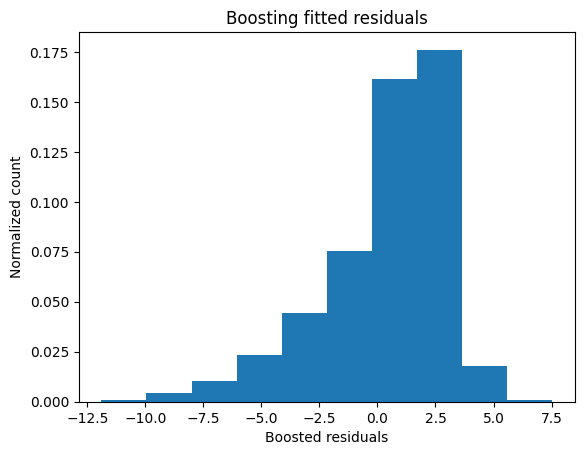

In [57]:
plt.hist(df['boostedResiduals'], density=True)
plt.xlabel("Boosted residuals")
plt.ylabel("Normalized count")
plt.title("Boosting fitted residuals")
plt.show()

In [58]:
df.boostedResiduals.isnull().sum(), df.linearPrediction.isnull().sum()

(0, 0)

In [59]:
df['finalPrediction'] = df['linearPrediction'] + df['boostedResiduals']

In [60]:
boostedresiduals_grouped = df.groupby(['loc_group'])
boostedresiduals_dict = {}

for name, group in boostedresiduals_grouped:

    rmse = np.sqrt(np.sum(group['boostedResiduals']**2) / group.shape[0])
    boostedresiduals_dict[name] = rmse

In [61]:
del group

In [62]:
sorted_boostedresiduals_dict = dict(sorted(boostedresiduals_dict.items(), key=lambda item: item[1]))
best_predicted_groups = list(sorted_boostedresiduals_dict.keys())[:4]
best_predicted_groups

[0, 45, 9, 75]

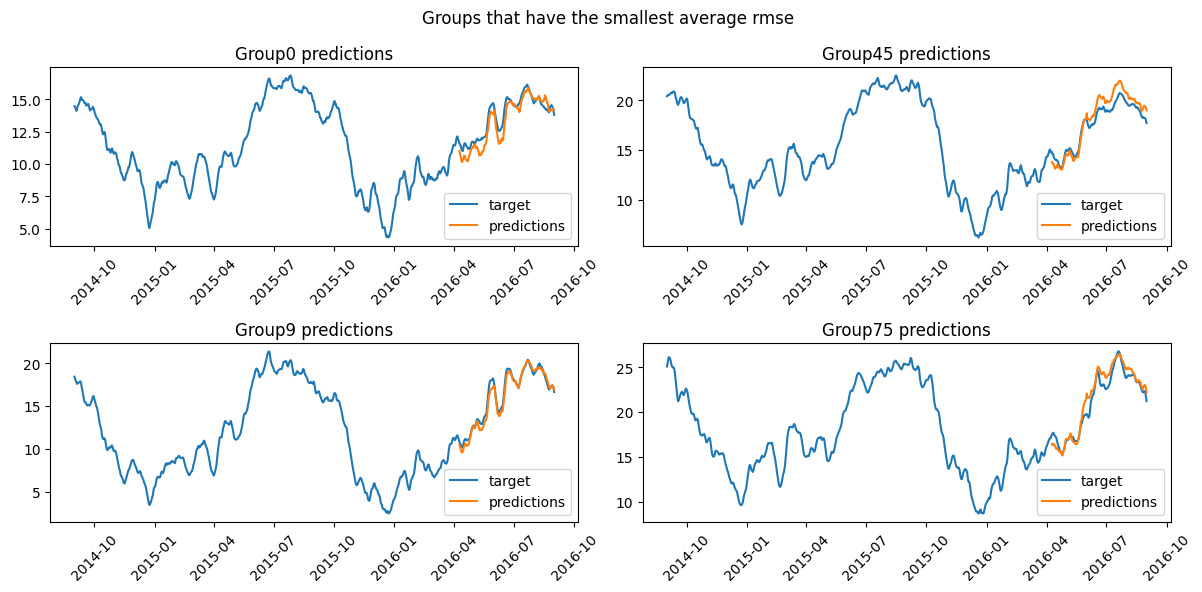

In [63]:
plt.figure(figsize=(12, 6))

for i, group in enumerate(best_predicted_groups):

    plt.subplot(2,2,i+1)
    train2_inds = train2.loc[train2.loc_group == group].index
    test_inds = test.loc[test.loc_group == group].index

    plt.plot(df.loc[df.loc_group == group, 'startdate'], df.loc[df.loc_group == group, target], label='target')
    plt.plot(df.loc[test_inds, 'startdate'], df.loc[test_inds, 'finalPrediction'], label='predictions')

    plt.title(f"Group{group} predictions")
    plt.xticks(rotation=45)
    plt.legend(loc='lower right')

plt.suptitle("Groups that have the smallest average rmse")
plt.tight_layout()